# Requirements to run

We recommend generatating a new Anaconda environment before trying to run this project.
The reason is that igraph may have dependencies that conflict with your other project configurations.
As a consequence a new Anaconda environment will likely lead to less debugging and conflicting package issues.

### If you miss a dependency
conda install -c conda-forge python-igraph <br/>
conda install -c conda-forge pycairo <br/>
conda install pandas

Note that the correct igraph package is listed at https://igraph.org/python/doc/tutorial/install.html and NOT at anaconda.org!

In [24]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import igraph as ig
import math
import numpy as np

In [79]:
#give filename as "id.json"
#1809.json
#546.json
controllables = {
    "Button Bar": "#FFCDD2",
    "Checkbox": "#FF8A65",
    "Date Picker": "#CC6699",
    "Icon": "#CC6699",
    "Input": "#90CAF9",
    "Number Stepper": "#AED581",
    "Radio Button": "#FFB74D",
    "Slider": "#CDDBDC",
    "Text Button": "#CDDC39"
}

tappables = ["BB", "I", "L", "TB"] 
verticesMap = {"Button Bar": "BB", "Checkbox": "C", "Icon": "I", "Input": "IP", "List Item": "L", "Text Button": "TB"}
edgesMap = {"BB": "Tap", "I": "Tap", "IP": "Input", "L": "Tap", "TB": "Tap"} 

## Extract components from file

In [3]:
def getNormalizedBounds(dimensions, bounds):
    x1 = bounds[0] / dimensions[2]
    y1 = bounds[1] / dimensions[3]
    x2 = bounds[2] / dimensions[2]
    y2 = bounds[3] / dimensions[3]
    return [x1, y1, x2, y2]

def sortControlComponents(components):
    sortedComponents = []
    for component in components:
        bounds = component[1]
        componentPosition = 0
        for i in range(len(sortedComponents)):
            compareTo = sortedComponents[i]
            compareToBounds = compareTo[1]
            #If the new component is below the previous one then we move 
            #it to towards the end of component ordering
            if bounds[1] > compareToBounds[3]:
                componentPosition += 1
            #if we have overlap between the components we choose by
            #the component ordering in horizontal plane
            elif bounds[0] > compareToBounds[2]:
                componentPosition += 1
            #otherwise we assume that the current component is before the other component
        sortedComponents.insert(componentPosition, component)
    return sortedComponents
        

def getControlComponents(children):
    controlComponents = []
    def loopForControlComponents(children):
        for c in children:
            clickable = c['clickable']
            if(clickable):
                controlComponents.append((clickable, c['bounds'], 
                                          c['componentLabel']))
            elif("children" in c):
                loopForControlComponents(c["children"])
                
    loopForControlComponents(children)
    ccCount = len(controlComponents)
    return controlComponents, ccCount

## Define Matrix Structure
The matrix is defined as such that any connection flowing downwards from a node above is marked in the matrix row that defines the node existing underneat it with a value 1. In other words if the first node flows to the leftmost node below it from the left we have a matrix:<br/>
[[0,0,0],<br/>
 [1,0,0],<br/>
 [0,0,0]]<br/>
 In the above definition one node is not connected to anything.
 If node on second level had a connection to two other nodes underneath it we would define the matrix as:<br/>
 [[0,0,0,0],<br/>
  [1,0,0,0],<br/>
  [0,1,0,0],<br/>
  [0,1,0,0]]<br/>

In [75]:
def defineAdjacencyMatrix(controlComponents, ccCount): 
    adjacencyMatrix =  [[0] * (ccCount+2)]
    endVector = [0] * (ccCount+2) 
    endpointsCounter = ccCount
    #this defines where the next nodes shall form connections
    currentAnchorColumn = 0
    
    for id in range(ccCount): 
            component = controlComponents[id]
            intermediateVector = []
            
            if(component[2] == 'Input'):
                intermediateVector = [0] * (ccCount+1) 
                intermediateVector.insert(currentAnchorColumn, 1) 
                currentAnchorColumn = id + 1
                endVector[id+1] = 0
                endpointsCounter -= 1
            else:
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[id+1] = 1
            adjacencyMatrix = adjacencyMatrix + [intermediateVector] 
            #endVector[id+1] = 1
    adjacencyMatrix = adjacencyMatrix + [endVector] 
    print("adjacencymatrix")
    for a in adjacencyMatrix:
        print(a)
    return adjacencyMatrix, endpointsCounter


def defineVertices(controlComponents): 
    verticeLabels = ["E"] 
    for c in controlComponents: 
        if(c[2] in verticesMap): 
            verticeLabels = verticeLabels + [verticesMap[c[2]]]
    #verticeLabels = ["E"] + verticeLabels 
    verticeLabels = verticeLabels + ["S"] 
    return verticeLabels 

def defineEdges(adjacencyMatrix, verticeLabels, endpointCount):
    edgeLabels = []
    noEndpoints = pd.DataFrame(adjacencyMatrix)
    print(noEndpoints)
    noEndpoints.drop(0,inplace=True)
    noEndpoints.drop(noEndpoints.tail(1).index,inplace=True)
    edgesPerLayer = noEndpoints.sum(axis=0) 
    edgesPerLayer= edgesPerLayer.iloc[edgesPerLayer.to_numpy().nonzero()[0]].to_numpy()
    #edgesPerLayer.loc[:, (edgesPerLayer != 0).any(axis=0)]
    print("--")
    print(noEndpoints)
    print("--")
    print(edgesPerLayer)
    
    currentEdgeGroup = 0
    workedThroughGroupItems = 0
    for v in range(len(verticeLabels)-1):
        print("V is", v, verticeLabels[v])
        if(verticeLabels[v] in edgesMap):
            
            edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
            currentEdge
        elif(verticeLabels[v] == "E"):
            edgeLabels = (["O"]*endpointCount) + edgeLabels
    #for v in range(len(verticeLabels)-1,-1,-1):
    #    print("V is", v, verticeLabels[v])
    #    if(verticeLabels[v] in edgesMap):
    #        edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
    #    elif(verticeLabels[v] == "E"):
    #        edgeLabels = (["O"]*endpointCount) + edgeLabels
    return edgeLabels

## Complexity Computations

In [26]:
def computeHalstead(edgeLabels, verticeLabels):
    #number of unique operators
    n1 = len(set(edgeLabels))
    #number of unique operands. We remove start and end
    n2 = len(set(verticeLabels))-2
    #total frequency of operators
    N1 = len(edgeLabels)
    #total frequency of operands. We remote start and end 
    N2 = len(verticeLabels)-2
    
    firstPart = (n1*N2*(N1+N2))/(2*n2)
    logPart = math.log(n1+n2, 2)
    #rounded to S significant numbers
    return round(firstPart*logPart,3)


def computeMcCabeVG(adjacencyMatrix):
    nodes = len(adjacencyMatrix)
    vertices = 0
    for a in adjacencyMatrix:
        vertices += a.count(1)
    return nodes - vertices

#called from computeWoodEntropy()
def woodComponentComplexity(adjacencyMatrix):
    print("xx")

def computeWoodEntropy(adjacencyMatrix):
    #print("type", type(adjacencyMatrix))
    print("")

## Call function and visualization

In [27]:
def getFile(fileName):
    data = json.load(open("hierarchies/"+fileName))
    dimensions = data['bounds']
    children = data['children']
    return dimensions, children

def visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels):
    directed = ig.Graph.Adjacency(adjacencyMatrix, mode="directed") 
    directed.vs["label"] = verticeLabels
    directed.es["label"] = edgeLabels
    layout = directed.layout("rt") 
    return ig.plot(directed, layout=layout, bbox=(0, 0, 350, 350), margin=20) 

def determineControlGraphForFile(file):
    dimensions, children = getFile(file)
    controlComponents, ccCount = getControlComponents(children)
    #we need to sort control components as they are not always
    #in a sensible order from the perspective of how the actions would be performed
    sortedControlComponents = sortControlComponents(controlComponents)
    for s in sortedControlComponents:
        print("C", s)
    adjacencyMatrix, endpointCount = defineAdjacencyMatrix(sortedControlComponents, ccCount)
    verticeLabels = defineVertices(sortedControlComponents)
    edgeLabels = defineEdges(adjacencyMatrix, verticeLabels, endpointCount)

    #complexity computation
    halstead = computeHalstead(edgeLabels, verticeLabels)
    mcCabe = computeMcCabeVG(adjacencyMatrix)
    wood = computeWoodEntropy(adjacencyMatrix)
    print("Halstead", halstead, "McCabe", mcCabe, "Wood", wood)
    return adjacencyMatrix, verticeLabels, edgeLabels

## ID 1809 computation

C (True, [195, 1763, 1245, 1973], 'Text Button')
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
   0  1  2
0  0  0  0
1  1  0  0
2  0  1  0
--
   0  1  2
1  1  0  0
--
[1]
V is 0 E
V is 1 TB

Halstead 4.755 McCabe 1 Wood None
['E', 'TB', 'S']
['O', 'Tap']


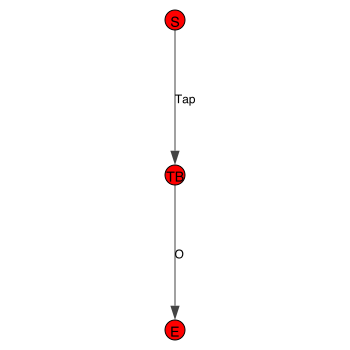

In [80]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("1809.json")
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

# Id 492 computation

C (True, [7, 89, 165, 247], 'Icon')
C (True, [35, 287, 193, 445], 'Icon')
C (True, [193, 287, 1288, 445], 'Text Button')
C (True, [1282, 296, 1422, 436], 'Icon')
C (True, [35, 2251, 1194, 2374], 'Input')
C (True, [1212, 2251, 1422, 2374], 'Text Button')
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0]
   0  1  2  3  4  5  6  7
0  0  0  0  0  0  0  0  0
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  0  0  0  0  0  1  0  0
7  0  1  1  1  1  0  1  0
--
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  0  0  0  0  0  1  0  0
--
[5 1]
V is 0 E
V is 1 I
V is 2 I
V is 3 TB
V is 4 I
V is 5 IP
V is 6 TB

Halstead 131.833 McCabe -3 Wood Non

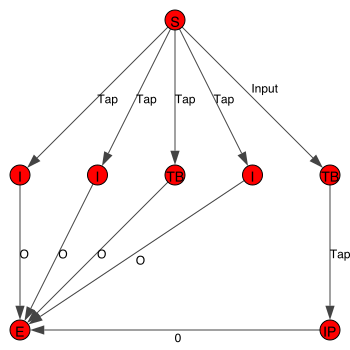

In [78]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("492.json")
print(verticeLabels)
print(edgeLabels)
#verticeLabels = ['E', 'I', 'I', 'TB', 'I', 'TB', 'IP', 'S']
edgeLabels = ['O', 'O', 'O', 'O', '0', 'Tap', 'Tap', 'Tap', 'Tap', 'Tap', 'Input']
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 1863 computation

[(True, [0, 0, 196, 196], 'Icon', 'android.widget.ImageButton'), (True, [247, 2140, 702, 2287], 'Text Button', 'android.support.v7.widget.AppCompatButton'), (True, [737, 2140, 1192, 2287], 'Text Button', 'android.support.v7.widget.AppCompatButton')]
adjacencymatrix
[0, 0, 0, 0, 0]
[1]
[1]
[1]
[0, 1, 1, 1, 0]
vertices 6
Halstead 27.0 McCabe -1


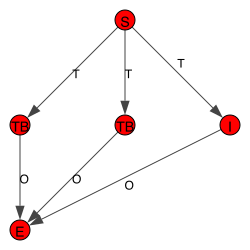

In [5]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("1863.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 546 computation

[(True, [0, 84, 196, 280], 'Icon', 'android.widget.ImageButton'), (True, [0, 284, 1440, 538], 'List Item', 'android.widget.LinearLayout'), (True, [0, 542, 1440, 796], 'List Item', 'android.widget.LinearLayout'), (True, [0, 800, 1440, 1054], 'List Item', 'android.widget.LinearLayout')]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 0]
vertices 8
Halstead 48.0 McCabe -2


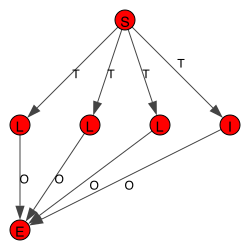

In [6]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("546.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 492 computation (needs fixing)

[(True, [7, 89, 165, 247], 'Icon', 'android.support.v7.widget.AppCompatImageButton'), (True, [35, 2251, 1194, 2374], 'Input', 'com.vanniktech.emoji.EmojiEditText'), (True, [1212, 2251, 1422, 2374], 'Text Button', 'android.support.v7.widget.AppCompatButton'), (True, [193, 287, 1288, 445], 'Text Button', 'android.widget.LinearLayout'), (True, [1282, 296, 1422, 436], 'Icon', 'android.support.v7.widget.AppCompatImageView'), (True, [35, 287, 193, 445], 'Icon', 'com.makeramen.roundedimageview.RoundedImageView')]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 1, 1, 0]
vertices 12
Halstead 80.0 McCabe -4


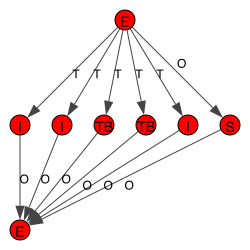

In [7]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("492.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 758 computation

[(False, [92, 759, 1348, 927], 'Text', 'android.widget.CheckedTextView'), (False, [92, 929, 1348, 1097], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1099, 1348, 1267], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1269, 1348, 1437], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1439, 1348, 1607], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1609, 1348, 1777], 'Text', 'android.widget.CheckedTextView'), (True, [92, 1779, 1348, 1947], 'Text Button', 'android.widget.Button')]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
vertices 19
Halstead 14.265 McCabe -10


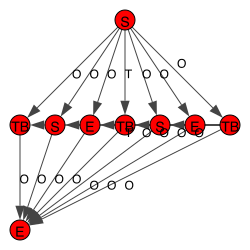

In [8]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("758.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

# Id 10596 computation

[(True, [0, 84, 196, 280], 'Icon', 'android.support.v7.widget.AppCompatImageButton'), (True, [1104, 98, 1272, 266], 'Icon', 'android.support.v7.view.menu.ActionMenuItemView'), (True, [1300, 140, 1384, 224], 'Icon', 'android.support.v7.widget.AppCompatImageView'), (True, [0, 308, 1440, 496], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 496, 1440, 684], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 684, 1440, 872], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 872, 1440, 1060], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1060, 1440, 1248], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1248, 1440, 1436], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1436, 1440, 1624], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1624, 1440, 1812], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1812, 1440, 2000], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 2000, 1440, 

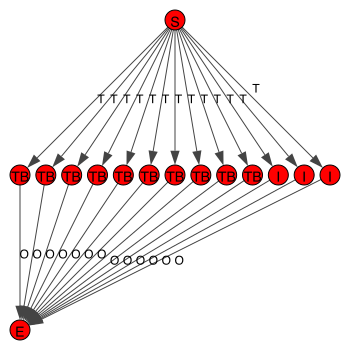

In [11]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("10596.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

# Id 1074 Computation

[(True, [0, 84, 169, 242], 'Icon', 'android.support.v7.widget.AppCompatImageView'), (True, [282, 817, 1157, 996], 'Input', 'com.careem.acma.ui.PinCodeEditText'), (True, [56, 1052, 1384, 1248], 'Text Button', 'com.careem.acma.widget.CustomFontButton'), (True, [813, 1304, 1210, 1381], 'Text Button', 'com.careem.acma.activity.FontTextView')]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 0]
vertices 8
Halstead 30.0 McCabe -2


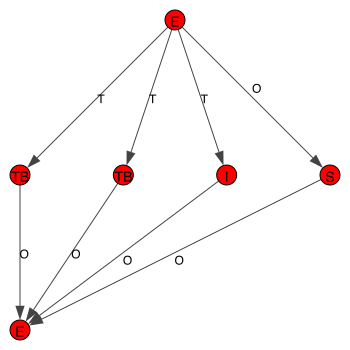

In [12]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("1074.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)